In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

In [3]:
class Value:    
    derivatives = {
        float.__add__: [
            lambda x, y: 1,
            lambda x, y: 1,
        ],
        float.__mul__: [
            lambda x, y: y,
            lambda x, y: x,
        ],
        float.__pow__: [
            lambda x, y: y * x**(y-1),
            lambda x, y: math.log(x) * x**y,
        ],
        math.exp: [
            lambda x: math.exp(x),
        ],
        math.tanh: [
            lambda x: 1 - math.tanh(x)**2
        ],
    }
    
    def __init__(self, v, label=None):
        self.v = v
        self.op = None
        self.args = []
        self.parents = set()
        self.grad = 0.0
        self.label = label
        
    @staticmethod
    def fromOp(op, args):
        args = [arg if isinstance(arg, Value) else Value(arg) for arg in args]
        value = Value(op(*(arg.v for arg in args)))
        value.op = op
        value.args = args
        for i, arg in enumerate(args):
            arg.parents.add((i, value))
        return value
    
    def id(self):
        return str(id(self))
    
    def calcGrad(self):
        self.grad = 0.0 if len(self.parents) > 0 else 1.0
        for i, p in self.parents:
            d = Value.derivatives[p.op][i]
            self.grad += d(*(arg.v for arg in p.args)) * p.grad
            
    def calcGradAll(self):
        used = set()
        nodes = []
        def dfs(v):
            if v not in used:
                used.add(v)
                for u in v.args:
                    dfs(u)
                nodes.append(v)
        dfs(self)
        for n in reversed(nodes):
            n.calcGrad()
        
    def __repr__(self):
        return f'Value(v={self.v},grad={self.grad})'
    
    def __add__(self, other):
        return Value.fromOp(float.__add__, [self, other])
    
    def __mul__(self, other):
        return Value.fromOp(float.__mul__, [self, other])
    
    def __sub__(self, other):
        return self + (other * -1)
    
    def __pow__(self, other):
        return Value.fromOp(float.__pow__, [self, other])
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def exp(self):
        return Value.fromOp(math.exp, [self])
    
    def tanh(self):
        return Value.fromOp(math.tanh, [self])
    
    def draw(self):
        dot = Digraph()
        used = set()
        def dfs(v):
            if v not in used:
                used.add(v)
                name = v.label or (v.op and v.op.__name__)
                dot.node(name=v.id(), label=f'{{ {name} | v={v.v:.2f} grad={v.grad:.2f} }}', shape='record')
                for u in v.args:
                    dfs(u)
                    dot.edge(u.id(), v.id())
        dfs(self)
        return dot

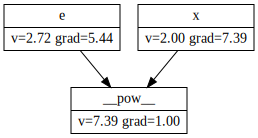

In [4]:
x = Value(2.0,'x')
y = Value(3.0,'y')
z = Value(4.0,'z')
L = Value(math.e,'e')**Value(2.0,'x')
L.calcGradAll()
L.draw()

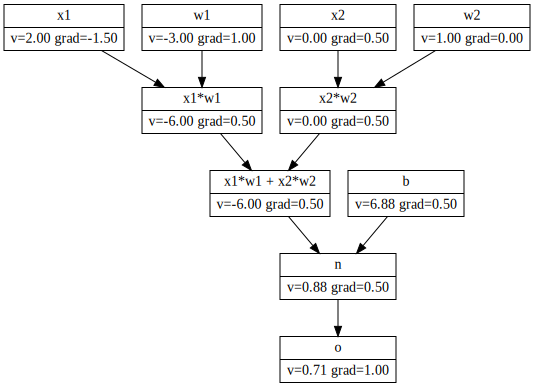

In [5]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8814, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#t = (n*2).exp(); t.label = 'exp(2n)'
#o = (t-1)/(t+1); o.label = 'o'
o = n.tanh(); o.label = 'o'
o.calcGradAll()
o.draw()